In [1]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import nltk # run nltk.download('punkt')
import spacy
spacy_nlp_spanish = spacy.load('es_core_news_sm') # run python -m spacy download es_core_news_sm
import es_core_news_sm
spacy_nlp_spanish = es_core_news_sm.load()


2024-05-14 15:25:37.302596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 15:25:39.784354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = load_dataset("ted_talks_iwslt", language_pair=("en", "es"), year="2016") # 3068 from 2014, 3764 from 15, and 4126 from 16

In [3]:
english_portion = [d['en'] for d in dataset['train']["translation"]]
spanish_portion = [d['es'] for d in dataset['train']["translation"]]

pre data cleaning statistics


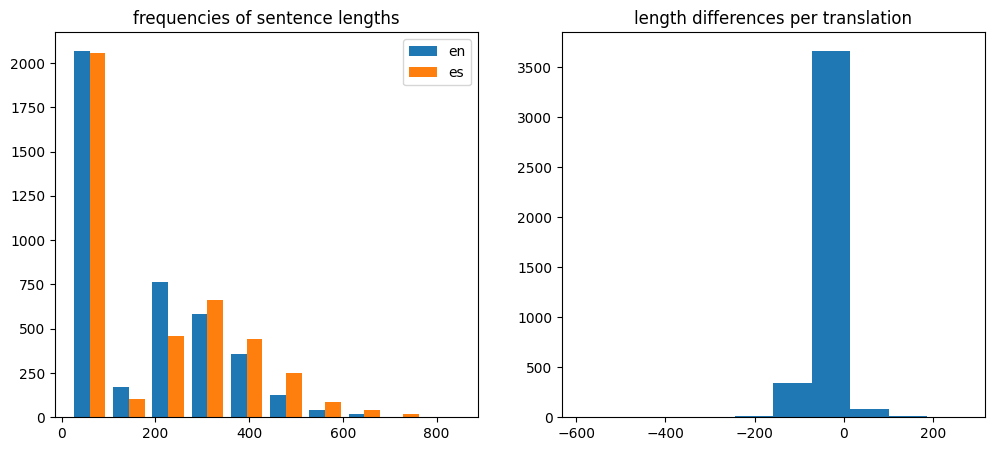

4126 4126
(274,
 376,
 102,
 'A liberal arts education is critical to forming true leaders, says '
 'university head Patrick Awuah -- because it builds decision-making skills, '
 'an ethical framework and a broad vision. Awuah himself left a career at '
 'Microsoft in the US to found a liberal arts school in Africa: Ashesi '
 'University, in his home nation of Ghana. A passionate talk about dreaming, '
 'doing and leading.',
 'Patrick Awuah argumenta que una educación artística liberal es crítica para '
 'formar verdaderos líderes.')
(-589,
 266,
 855,
 'Why is Al Gore optimistic about climate change? In this spirited talk, Gore '
 'asks three powerful questions about the man-made forces threatening to '
 "destroy our planet -- and the solutions we're designing to combat them. "
 '(Featuring Q&A with TED Curator Chris Anderson)',
 'Al Gore plantea tres preguntas sobre el cambio climático y nuestro futuro. '
 'En primer lugar: ¿Tenemos que cambiar? Cada día, la contaminación del '
 'cal

In [4]:
def plot_stats(english_portion, spanish_portion):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5) )
    # plt.rcParams['figure.dpi'] = 300
    axs[0].set_title("frequencies of sentence lengths")
    axs[0].hist(([len(s) for s in english_portion], [len(s) for s in spanish_portion]), label=["en", 'es'])
    axs[0].legend()
    axs[1].set_title("length differences per translation")
    axs[1].hist([(len(en) - len(es)) for en, es in zip(english_portion, spanish_portion)])
    plt.show()
print("pre data cleaning statistics")
plot_stats(english_portion, spanish_portion)
len_diffs = [(len(en) - len(es), len(en), len(es), en, es) for en,es in zip(english_portion, spanish_portion)]
print(len(spanish_portion), len(english_portion))
pprint(max(len_diffs))
pprint(min(len_diffs))


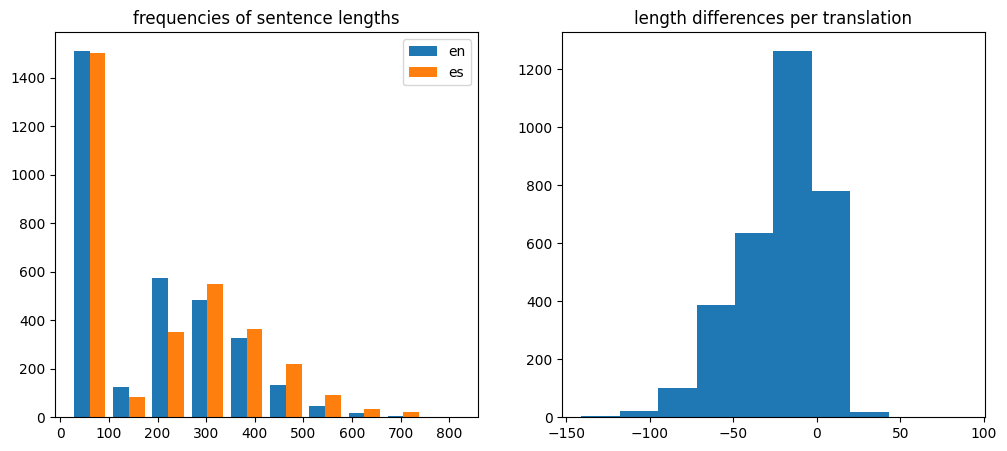

3220 3220
(89,
 514,
 425,
 "Camels are so well adapted to the desert that it's hard to imagine them "
 'living anywhere else. But what if we have them pegged all wrong? What if '
 'those big humps, feet and eyes were evolved for a different climate and a '
 "different time? In this talk, join Radiolab's Latif Nasser as he tells the "
 'surprising story of how a very tiny, very strange fossil upended the way he '
 'sees camels, and the world. This talk comes from the upcoming PBS special '
 'TED Talks: Science & Wonder, which premieres March 30th at 10 p.m. ET.',
 'Los camellos están tan bien adaptados al desierto que es difícil imaginarlos '
 'en otro lugar. Pero ¿y si los hemos catalogado mal? ¿Y si desarrollaron esas '
 'grandes jorobas, esas amplias pezuñas  y esos ojos enormes para un clima y '
 'una era diferente? En esta charla, súmate a Latif Nasser de Radiolab '
 'conforme cuenta la sorprendente historia de cómo un diminuto y singular '
 'fósil trastocó su forma de ver los cam

In [5]:
# get largest sentence length difference:
english_portion_filtered = []
spanish_portion_filtered = []
ratio = 10/8
len_diffs = [(len(en) - len(es), len(en), len(es), en, es) for en,es in zip(english_portion, spanish_portion)]
for len_diff in len_diffs:
    if (1/ratio < len_diff[1]/len_diff[2] < ratio) or abs(len_diff[1] - len_diff[2]) < 10:
        english_portion_filtered.append(len_diff[-2])
        spanish_portion_filtered.append(len_diff[-1])

len_diffs = [(len(en) - len(es), len(en), len(es), en, es) for en,es in zip(english_portion_filtered, spanish_portion_filtered)]
plot_stats(english_portion_filtered, spanish_portion_filtered)
print(len(spanish_portion_filtered), len(english_portion_filtered))
pprint(max(len_diffs))
pprint(min(len_diffs))

In [6]:
print(f"english dataset length, and then set length for duplicate detection:", len(english_portion), len(set(english_portion)))
print(f"spanish dataset length, and then set length for duplicate detection:", len(spanish_portion), len(set(spanish_portion)))
# for s in set(spanish_portion):
#     spanish_portion.remove(s)
# spanish_portion
print("only one repeated sentence, which is in spanish: ['La biblioteca de la imaginación humana de Jay Walker']")

english dataset length, and then set length for duplicate detection: 4126 4126
spanish dataset length, and then set length for duplicate detection: 4126 4125
only one repeated sentence, which is in spanish: ['La biblioteca de la imaginación humana de Jay Walker']


In [7]:
# creating the IBM translation model 1:
# the setup here, is we are trying to find the translation pairs. 
# We first off want to maximize the likelihood of translation from spanish to english under the model of p(e | s) ~ p(e) * p(s | e), 
# as our spanish sentence doesn't need to consider it's likelihood.
# 
# 
# need to have parameters for translation first, and then need to have parameters for 
# spanish_voc = 

spacy_word_tokenize = lambda s: [w.text for w in spacy_nlp_spanish(s)]
english_tokens = [nltk.word_tokenize(s) for s in english_portion_filtered]
spanish_tokens = [spacy_word_tokenize(s) for s in spanish_portion_filtered]
# nltk.word_tokenize("Economic growth is the defining challenge of our time; without it, political")

In [ ]:
from collections import Counter

In [ ]:
def create_voc(tokens, new_tokens=[]):
    threshold = 10
    tokens_above_threshold = sorted(list(filter(lambda x: x[1] > threshold, Counter(w for s in tokens for w in s).items())))
    tokens_above_threshold = new_tokens + [w for w, _ in tokens_above_threshold]
    
    voc2indx = {w: i for i, w in enumerate(tokens_above_threshold)}

    indx2voc = list(voc2indx.keys())
    return voc2indx, indx2voc

voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens, new_tokens=["<NULL>"])
voc2indx_english, indx2voc_english = create_voc(english_tokens, new_tokens=["<NULL>", "<UNK>"])

In [ ]:
def create_en_and_es_dataset(english_tokenized, spanish_tokenized, voc2indx_english, voc2indx_spanish):
    english_tokens_with_unk = [[(w if w in voc2indx_english else "<UNK>") for w in s]+["<NULL>"] for s in english_tokenized]
    spanish_tokens_with_unk = [[(w if w in voc2indx_spanish else "<UNK>") for w in s] for s in spanish_tokenized]
    return english_tokens_with_unk, spanish_tokens_with_unk
english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens, spanish_tokens, voc2indx_english, voc2indx_spanish)

In [ ]:
def create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk):
    data = list(zip(english_tokens_with_unk, spanish_tokens_with_unk))
    return data
def create_empty_model(data):
    paired_tokens = []
    for english_sentence, spanish_sentence in data:
        for e in english_sentence:
            for s in spanish_sentence:
                paired_tokens.append((s,e))
    model_p = {k: 0 for k in set(paired_tokens)}
    return model_p
data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)
model_p = create_empty_model(data)

In [12]:
# the p(s | e), and then some prior for the location of the word.
# the thing we want to determine is p(a | f, e)
# E and M between finding the best allignment for the probability model on the text alignment, and the best alignment for the model.
# p(a | f, e) * p(f | e) = p(f | e, a) * p(a | e), where p(f | e) = sum_{a \in all alignments}{p(f | a, e) * p(a | e)}
# under model 1, the alignment model p(a | e) is simply the uniform over the sentence: 1 / (l + 1)
# we really want to decompose each decision to be per word, so the following model is what we use:
# the alignment is the latent variable, where you have one latent for every word in every sentence representing where it is aligned to in the english sentence.
# p(a_j | f_j, e) * p(f_j | e) = p(f_j | a_j, e) * p(a_j | e), where now p(f_j | e) = sum_{i in l + 1}{p(f | a_j=i, e) * p(a_j = i | e)}

# with p(a_j = i | e) being 1/ (l+1) still for model 1
# I see that I need to change the p(f | e), on a per word basis, but how do I change the alignments? Do I pick the most probable ones? 
# or just pick the asignments on a simplex ie softly?

In [13]:
# first randomly init params for a new model
def inplace_init_model_params(model):
    num_spanish_words = len(set(k[0] for k in model))
    for key in model:
        model[key] = 1 / num_spanish_words
inplace_init_model_params(model_p)


In [14]:
# E step: creating counts for which it is easy to do the maximization step for.
def perform_E_step(model, data):
    counts_for_s_j_e_i_pairs = {k: 0 for k in model}
    for e, s in data:
        for s_j in s:
            p_s_j_given_e_without_q_a = sum(model[(s_j, e_k)] for e_k in e)
            for e_i in e:
                counts_for_s_j_e_i_pairs[(s_j, e_i)] += model[(s_j, e_i)] / p_s_j_given_e_without_q_a# the count of the spanish and english copairs.
                # They occur with eachother depending on the probability of alignment p(a_j = i | f_j, e)
                # can you use the entire sentence of s's to evaluate the alignment? This would make the bayes model more complex:
                # p(a_j = i | f, e) p(f | e) <- you need this model = p(f | a_j = i, e) <- this model doesn't make sense, so you need to basically combine all your alignments.
                # then you have p(a | f, e), and you have a full alignment model, and no easy way to optimize???
    return counts_for_s_j_e_i_pairs
counts_for_s_j_e_i_pairs = perform_E_step(model_p, data)

In [15]:
# M step:
def perform_M_step(counts_for_s_j_e_i_pairs):
    counts_for_e_i = {u: 0 for u in set(k[1] for k in counts_for_s_j_e_i_pairs)}
    for pair, value in counts_for_s_j_e_i_pairs.items():
        counts_for_e_i[pair[1]] += value

    new_model = {k: v / counts_for_e_i[k[1]]  for k, v in counts_for_s_j_e_i_pairs.items()}
    return new_model

new_model_p = perform_M_step(counts_for_s_j_e_i_pairs)

In [16]:
# evaluate the log_likelihood
def get_likelihood(model, data):
    likelihood = 0 # ignoring the model for e, just minimize your probability under your model for the 
    for e, s in data:
        # probability of an alignment p(f | e) = Prod_j{ sum_{alignments}{ p(f_j|a_j, e) * p(a_j | e)} }
        for s_j in s:
            likelihood += np.log(1/len(e)) + np.log(sum(model[(s_j, e_i)] for e_i in e))
    return likelihood
get_likelihood(model_p, data), get_likelihood(new_model_p, data)

(-871609.611068914, -509568.03483459953)

In [17]:
# do this in a loop:
def optimize_model(model_p, data, perform_E_step, perform_M_step, get_likelihood):
    num_epochs = 10
    last_likelihood = 0
    for epoch in range(num_epochs):
        counts_for_s_j_e_i_pairs = perform_E_step(model_p, data)
        new_model_p = perform_M_step(counts_for_s_j_e_i_pairs)
        new_likelihood = get_likelihood(new_model_p, data)
        print(f"epoch {epoch=}, with likelihood=", new_likelihood)
        if last_likelihood == new_likelihood:
            break
        last_likelihood = new_likelihood
        model_p = new_model_p
    return model_p
model_p = optimize_model(model_p, data, perform_E_step, perform_M_step, get_likelihood)


epoch epoch=0, with likelihood= -509568.03483459953
epoch epoch=1, with likelihood= -469732.95852562995
epoch epoch=2, with likelihood= -447415.1996407567
epoch epoch=3, with likelihood= -437916.6359590436
epoch epoch=4, with likelihood= -433379.4022666768
epoch epoch=5, with likelihood= -430847.66968394944
epoch epoch=6, with likelihood= -429248.65894737176
epoch epoch=7, with likelihood= -428150.48669710866
epoch epoch=8, with likelihood= -427355.4868860529
epoch epoch=9, with likelihood= -426759.2274307297


In [19]:
# english to english to visualize ambiguities in the model, specifically ones which can easily be solved by a more accurate position prior.

# voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens, new_tokens=["<NULL>"])
voc2indx_english, indx2voc_english = create_voc(english_tokens, new_tokens=["<NULL>", "<UNK>"])
voc2indx_english0, indx2voc_english0 = create_voc(english_tokens, new_tokens=["<NULL>"])
english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens, english_tokens, voc2indx_english, voc2indx_english0)
data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)
model_p = create_empty_model(data)
inplace_init_model_params(model_p)
print(f"starting likelihood: {(get_likelihood(model_p, data))}")
model_p = optimize_model(model_p, data, perform_E_step, perform_M_step, get_likelihood)



starting likelihood: -810764.5064618264
epoch epoch=0, with likelihood= -482233.3330351652
epoch epoch=1, with likelihood= -404384.8926266134
epoch epoch=2, with likelihood= -365642.55940508656
epoch epoch=3, with likelihood= -353090.00473416905
epoch epoch=4, with likelihood= -347941.1196984507
epoch epoch=5, with likelihood= -345321.0988599758
epoch epoch=6, with likelihood= -343773.93500375556
epoch epoch=7, with likelihood= -342761.83320770366
epoch epoch=8, with likelihood= -342052.8103791087
epoch epoch=9, with likelihood= -341532.8717563879


In [18]:
len_sentences = list(zip([len(e) for e in english_tokens], [len(s) for s in spanish_tokens]))
english_tokens_filtered = []
spanish_tokens_filtered = []
count_english_lens = Counter([len(e) for e in english_tokens])
count_spanish_lens = Counter([len(s) for s in spanish_tokens])
threshold = 4
for i, (l, m) in enumerate(len_sentences):
    if count_english_lens[l] >= threshold and count_spanish_lens[m] >= threshold:
        english_tokens_filtered.append(english_tokens[i])
        spanish_tokens_filtered.append(spanish_tokens[i])
print(len(english_tokens_filtered), len(spanish_tokens_filtered))

3154 3154


In [21]:
def create_empty_model_2(data):
    # need to have model parameters in the form of p(f_j | e_i) pairs, and in the form of positional conditioning, with q(i | j, m, l)
    pairs = []
    position_pairs = []
    for e, s in data:
        l, m = len(e), len(s)
        for i, e_i in enumerate(e):
            for j, s_j in enumerate(s):
                pairs.append((s_j, e_i))
                position_pairs.append((i, j, m, l))
    model = {p:0 for p in list(set(pairs)) + list(set(position_pairs))}
    return model
model_p = create_empty_model_2(data)

In [22]:
print([min((len(sent),sent) for sent in sentences) for sentences in zip(*data)])
# TODO: fix the problem of sentences with too many unks, by filtering them out? And then might need to recreate the dictionary, and repeat the process of filtering out unk words which have few occurances and then filtering out sentences yet again.

[(6, ['<UNK>', ':', 'The', '<UNK>', 'me', '<NULL>']), (4, ['Jonathan', '<UNK>', '<UNK>', 'historias'])]


In [23]:
def inplace_init_model_2_params(model):
    # need to init the model parameters to a reasonable baseline, try uniform again. with p(f_j | e_i) uniform over the words f_j in the model for all the conditionals.
    num_s = len(set(p[0] for p in model if len(p) == 2)) 
    # want to ignore the len 4 which represents positional, for that I will do uniform over the l avaialble position alignments
    for key in model.keys():
        if len(key) == 2:
            model[key] = 1 / num_s
        elif len(key) == 4:
            model[key] = 1 / key[-1]
        else:
            raise Exception(f"Should only have 4 and 2 length parameters in the dict's keys, but got key: {key}")
inplace_init_model_2_params(model_p)

In [24]:
print([len(set((len(sent)) for sent in sentences)) for sentences in zip(*data)])

[123, 132]


In [25]:
def get_likelihood_model_2(model, data):
    # p(f | e)  = p( |f|  | e) * Prod_j  Sum_i(p(f_j | a_j, e) * p(a_j = i | j, |f|, |e|, e))
    # p( |f|  | e)  = 1 / 96 for now, 
    # TODO: fix to be correct probabilty. Could just be figured out by the data. 
    # I will just set a uniform over the true number of unique sentence lengths.
    likelihood = 0
    for e, s in data:
        l, m = len(e), len(s)
        likelihood += np.log(1 / 96)
        for j, s_j in enumerate(s):
            likelihood += np.log(
                sum(model[(s_j, e_i)] * model[(i, j, m, l)] for i, e_i in enumerate(e))
            )
    return likelihood
get_likelihood_model_2(model_p, data)

-886306.8122454421

In [26]:
def perform_E_step_model_2(model, data):
    counts = {key: 0 for key in model}
    # get the expected counts when your model would be sampled under your latent parameters. This is the alignment probabilities that your model has.
    for e, s in data:
        l, m = len(e), len(s)
        for j, s_j in enumerate(s):
            normalizing_const = sum(model[(s_j, e_k)] * model[(k, j, m, l)] for k, e_k in enumerate(e))
            for i, e_i in enumerate(e):
                counts[(i, j, m, l)] += model[(s_j, e_i)] * model[(i, j, m, l)] / normalizing_const # add event that i occurs with j. this is based on the probability of the alignment given the french and english no?
                counts[(s_j, e_i)] += model[(s_j, e_i)] * model[(i, j, m, l)] / normalizing_const # add the event that s_j aligns with e_i for this sentence: 
                # p(a_j = i | f_j, e)  * p(|f| | e) sum_k(p(f_j | a_j=k, e) * p(a_j=k | i, |f|, |e|, e)) = p(f_j | a_j = i, e) * p(a_j = i | i, |f|, |e|, e) * p(|f| | e)
                # p(a_j = i | f_j, e) =  p(f_j | a_j = i, e) * p(a_j = i | i, |f|, |e|, e) / sum_k(p(f_j | a_j=k, e) * p(a_j=k | i, |f|, |e|, e))

    return counts
counts = perform_E_step_model_2(model_p, data)

In [27]:
def perform_M_step_model_2(counts):
    new_model_p = dict()
    normalizing_counts = Counter()
    for key, count in counts.items():
        normalizing_counts[key[1:]] += count
    new_model_p = {key: count / normalizing_counts[key[1:]] for key, count in counts.items()}
    return new_model_p
new_model_p = perform_M_step_model_2(counts)

In [36]:
voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens_filtered, new_tokens=["<NULL>"])
voc2indx_english, indx2voc_english = create_voc(english_tokens_filtered, new_tokens=["<NULL>", "<UNK>"])
# voc2indx_english0, indx2voc_english0 = create_voc(english_tokens_filtered, new_tokens=["<NULL>"])
english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens_filtered, spanish_tokens_filtered, voc2indx_english, indx2voc_spanish)
data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)
model_p = create_empty_model_2(data)
inplace_init_model_2_params(model_p)
print(f"starting likelihood: {(get_likelihood_model_2(model_p, data))}")
model_p = optimize_model(model_p, data, perform_E_step_model_2, perform_M_step_model_2, get_likelihood_model_2)

starting likelihood: -831979.5985877505
epoch epoch=0, with likelihood= -490539.3986787033
epoch epoch=1, with likelihood= -404575.6224341665
epoch epoch=2, with likelihood= -315761.0703978876
epoch epoch=3, with likelihood= -259147.3530734786
epoch epoch=4, with likelihood= -213536.93665181322
epoch epoch=5, with likelihood= -182067.16616245802
epoch epoch=6, with likelihood= -166586.5897785949
epoch epoch=7, with likelihood= -159675.19139906843
epoch epoch=8, with likelihood= -156303.03081011726
epoch epoch=9, with likelihood= -154438.79322711463


In [ ]:
# english 2 english
# under model 1: starting likelihood: -810764.5064618264
# epoch epoch=0, with likelihood= -482233.3330351652
# epoch epoch=1, with likelihood= -404384.8926266134
# epoch epoch=2, with likelihood= -365642.55940508656
# epoch epoch=3, with likelihood= -353090.00473416905
# epoch epoch=4, with likelihood= -347941.1196984507
# epoch epoch=5, with likelihood= -345321.0988599758
# epoch epoch=6, with likelihood= -343773.93500375556
# epoch epoch=7, with likelihood= -342761.83320770366
# epoch epoch=8, with likelihood= -342052.8103791087
# epoch epoch=9, with likelihood= -341532.8717563879

# under model 2: starting likelihood: -773022.7161972101
# epoch epoch=0, with likelihood= -462290.9706145603
# epoch epoch=1, with likelihood= -289209.87861828593
# epoch epoch=2, with likelihood= -102219.52982528713
# epoch epoch=3, with likelihood= -28093.816094111553
# epoch epoch=4, with likelihood= -16030.130320738148
# epoch epoch=5, with likelihood= -14790.177472912908
# epoch epoch=6, with likelihood= -14559.907509435521
# epoch epoch=7, with likelihood= -14486.988450472141
# epoch epoch=8, with likelihood= -14455.438355445734
# epoch epoch=9, with likelihood= -14438.807682623446

In [ ]:
# english 2 spanish:
# epoch epoch=0, with likelihood= -509568.03483459953
# epoch epoch=1, with likelihood= -469732.95852562995
# epoch epoch=2, with likelihood= -447415.1996407567
# epoch epoch=3, with likelihood= -437916.6359590436
# epoch epoch=4, with likelihood= -433379.4022666768
# epoch epoch=5, with likelihood= -430847.66968394944
# epoch epoch=6, with likelihood= -429248.65894737176
# epoch epoch=7, with likelihood= -428150.48669710866
# epoch epoch=8, with likelihood= -427355.4868860529
# epoch epoch=9, with likelihood= -426759.2274307297

# starting likelihood: -831979.5985877505
# epoch epoch=0, with likelihood= -490539.3986787033
# epoch epoch=1, with likelihood= -404575.6224341665
# epoch epoch=2, with likelihood= -315761.0703978876
# epoch epoch=3, with likelihood= -259147.3530734786
# epoch epoch=4, with likelihood= -213536.93665181322
# epoch epoch=5, with likelihood= -182067.16616245802
# epoch epoch=6, with likelihood= -166586.5897785949
# epoch epoch=7, with likelihood= -159675.19139906843
# epoch epoch=8, with likelihood= -156303.03081011726
# epoch epoch=9, with likelihood= -154438.79322711463


In [37]:
def get_alignment_matrix(model, en, es):
    p_a_j_given_f_j_e = np.zeros((len(en), len(es)), dtype=np.float32)
    for j, s_j in enumerate(es):
        normalizing_spanish_prob_f_j_given_e_without_q = sum(model[(s_j, e_k)] for e_k in en)
        for i, e_i in enumerate(en):
            p_a_j_given_f_j_e[i,j] = round(model[(s_j, e_i)] / normalizing_spanish_prob_f_j_given_e_without_q, 2)
    return p_a_j_given_f_j_e

def visualize_sentence_alignments(p_a_j_given_f_j_e, en, es):
    fig, ax = plt.subplots(figsize = (len(es) * 0.5, len(en) * 0.5))
    im = ax.imshow(p_a_j_given_f_j_e)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(es)), labels=es)
    ax.set_yticks(np.arange(len(en)), labels=en)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(en)):
        for j in range(len(es)):
            text = ax.text(j, i, p_a_j_given_f_j_e[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("es to en alignment probs (p(a_j | f_j, e))") 
    # does it make sense to use these probabilities, what do I want to know?
    # I do want to know about how likely some word is to align with this word, 
    # but I think this probability should sum to one over the english words, 
    # because you must align to some word. so then p(a_j | f_j, e) seems correct.
    # to calculate, seems to use bayes rule likely related to one of the updates.
    # p(a_j = a_j | f_j, e) = p(f_j | a_j, e) * p(a_j = a_j | e) / (sum_k(p(f_j | a_j = k, e)) * p(a_j = * | e))-> const cancels
    fig.tight_layout()
    plt.show()

# visualize_sentence_alignments(
#     en = ['David', 'Cameron', ':', 'The', 'next', 'age', 'of', 'government', '<NULL>'],
#     es = ['David', 'Cameron', ':', 'La', 'próxima', 'era', 'de', 'gobierno']
# )


In [38]:
def get_alignment_matrix_model_2(model, en, es):
    # english x spanish , and get the probability of alignment  p(a_j =i | f_j, e) = p(f_j | a_j=i, e) * p(a_j=i | i, |f|, |e|, e) / sum_i(p(f_j | a_j=i, e) * p(a_j=i | i, |f|, |e|, e))
    p_a_j_given_f_j_e = np.zeros((len(en), len(es)), dtype=np.float32)
    l, m = len(en), len(es)
    for j, s_j in enumerate(es):
        normalizing_const = sum(model[(s_j, e_k)] * model[(k, j, m, l)] for k, e_k in enumerate(en))
        for i, e_i in enumerate(en):
            p_a_j_given_f_j_e[i, j] = round(model[(s_j, e_i)] * model[(i, j, m, l)] / normalizing_const, 2)
    return p_a_j_given_f_j_e


2806 ['<UNK>', '<UNK>', '<UNK>', 'performs', 'the', '<UNK>', 'song', '``', '<UNK>', "''", '--', 'about', 'creating', 'the', '<UNK>', '<UNK>', '.', '<NULL>'] ['La', '<UNK>', 'y', '<UNK>', '<UNK>', '<UNK>', 'canta', 'la', 'casi', '<UNK>', 'canción', '"', '<UNK>', '"', '--', 'acerca', 'de', 'cómo', 'crear', 'la', 'mejor', '<UNK>', '.']
['Singer-songwriter', 'Nellie', 'McKay', 'performs', 'the', 'semi-serious', 'song', '``', 'Clonie', "''", '--', 'about', 'creating', 'the', 'ultimate', 'companion', '.']
['La', 'cantante', 'y', 'compositora', 'Nellie', 'McKay', 'canta', 'la', 'casi', 'seria', 'canción', '"', 'Clonie', '"', '--', 'acerca', 'de', 'cómo', 'crear', 'la', 'mejor', 'compañera', '.']


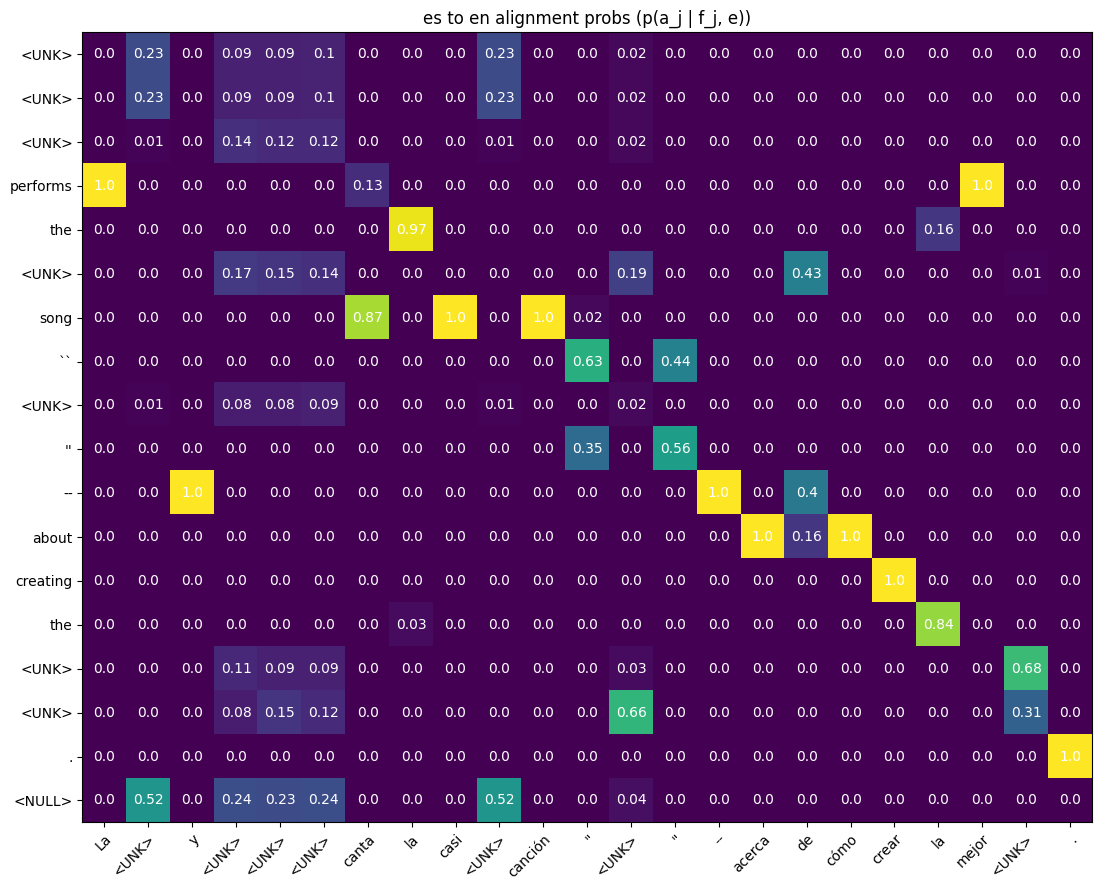

In [42]:
# look at alignments gotten for particular sentences:
for i, (e, s) in enumerate(data):
    if 10 < len(e) < 20 and ":" not in e and i not in [1, 2386, 2724, 3177] :
        print(i, e, s)# need to make a grid for the sentences and put the p(a_j = i | f_j, e)
        print(english_tokens_filtered[i])
        print(spanish_tokens_filtered[i])
        # english on the rows and columns are the spanish.
        visualize_sentence_alignments(get_alignment_matrix_model_2(model_p, e, s), e,s)
        break